In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from torchvision.models import mobilenet_v2
from torch.utils.data import TensorDataset,DataLoader
from PIL import Image
import torch.optim as optim

In [ ]:
img_train = np.load('/content/drive/MyDrive/data_transfer/images_train.npy')

In [ ]:
img_val = np.load('/content/drive/MyDrive/data_transfer/images_valid.npy')
img_test = np.load('/content/drive/MyDrive/data_transfer/images_test.npy')

In [ ]:
label_train = np.load('/content/drive/MyDrive/data_transfer/labels_train.npy')
label_val = np.load('/content/drive/MyDrive/data_transfer/labels_valid.npy')
label_test = np.load('/content/drive/MyDrive/data_transfer/labels_test.npy')

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_label = torch.Tensor(label_train)
test_label = torch.Tensor(label_test)

train_label = torch.unsqueeze(train_label,1)
test_label = torch.unsqueeze(test_label,1)

In [ ]:
train_label.shape

torch.Size([600, 1])

In [ ]:
train_set = torch.zeros(600,3,224,224)
test_set = torch.zeros(300,3,224,224)

In [ ]:
for i in range(img_train.shape[0]):
  image = Image.fromarray(img_train[i].astype(np.uint8),mode = 'RGB')
  img_tensor = preprocess(image)
  train_set[i] = img_tensor

In [ ]:
train_set.shape

torch.Size([600, 3, 224, 224])

In [ ]:
img_test.shape[0]

300

In [ ]:
for i in range(img_test.shape[0]):
  image = Image.fromarray(img_test[i].astype(np.uint8),mode = 'RGB')
  img_tensor = preprocess(image)
  test_set[i] = img_tensor

In [ ]:
trainset = TensorDataset(train_set,train_label)
testset = TensorDataset(test_set,test_label)

In [ ]:
trainloader = DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2)

In [ ]:
model = mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
layers = list(model.children())

In [ ]:
len(layers)

2

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
model.classifier = nn.Sequential(nn.Linear(1280,32,bias = False),
                                    nn.ReLU(),
                                    nn.Dropout(0.5),
                                    nn.Linear(32,1,bias = False))

In [ ]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

40992

In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
if use_gpu:
  model = model.cuda()

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
num_epochs = 10
train_loss = []
train_acc = []

for i in range(num_epochs):
  running_loss = 0.
  running_acc = 0.
  for idx,data in enumerate(trainloader):
    inputs,labels = data
    if use_gpu:
      inputs,labels = inputs.cuda(),labels.cuda()
    
    optimizer.zero_grad()

    output = model(inputs)
    loss = criterion(output,labels)
    preds = (output > 0.5).float()

    running_loss += loss.item()
    running_acc += torch.sum(preds == labels)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss/(i+1)
  epoch_acc = running_acc.item()/600

  train_loss.append(epoch_loss)
  train_acc.append(epoch_acc)
  
  print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(i+1,num_epochs,epoch_loss,epoch_acc*100))

Epoch 1/10 : Training loss: 10.2060 | Training Accuracy: 69.3333
Epoch 2/10 : Training loss: 2.8469 | Training Accuracy: 89.1667
Epoch 3/10 : Training loss: 1.3173 | Training Accuracy: 93.0000
Epoch 4/10 : Training loss: 0.9208 | Training Accuracy: 92.1667
Epoch 5/10 : Training loss: 0.6575 | Training Accuracy: 92.5000
Epoch 6/10 : Training loss: 0.5311 | Training Accuracy: 93.3333
Epoch 7/10 : Training loss: 0.4775 | Training Accuracy: 93.6667
Epoch 8/10 : Training loss: 0.2915 | Training Accuracy: 95.3333
Epoch 9/10 : Training loss: 0.2469 | Training Accuracy: 94.0000
Epoch 10/10 : Training loss: 0.2177 | Training Accuracy: 95.8333


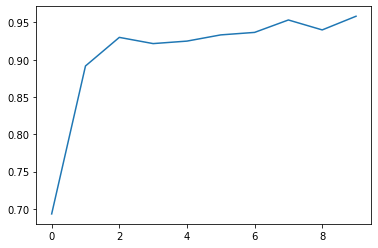

In [ ]:
plt.plot(train_acc)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]], device='cuda:0')
Testing accuracy =  94.66666666666667


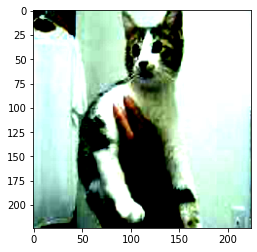

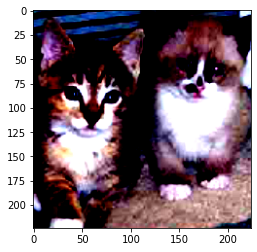

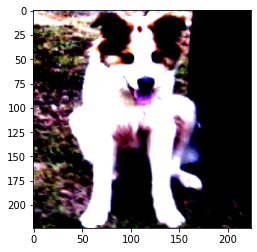

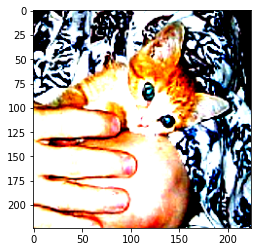

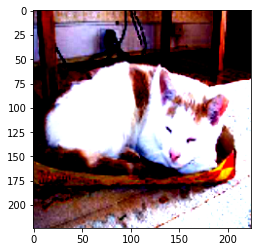

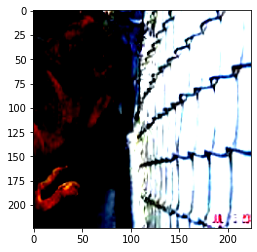

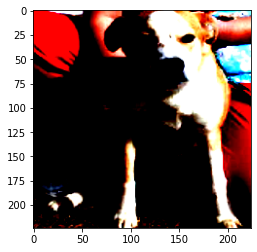

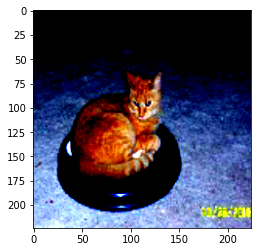

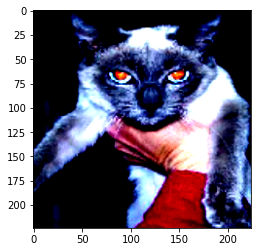

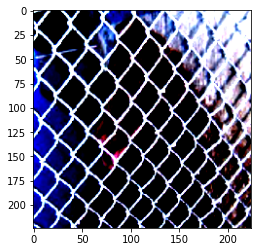

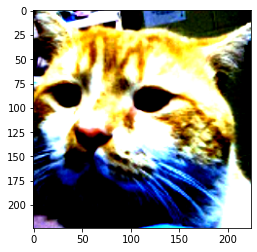

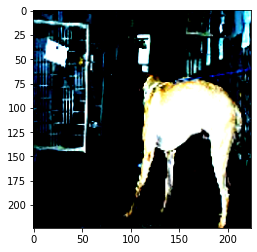

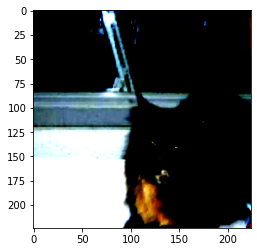

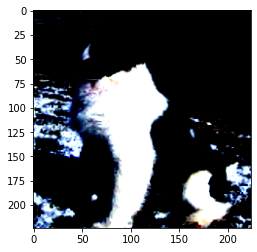

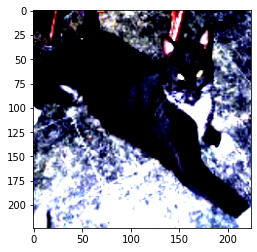

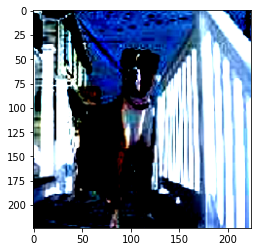

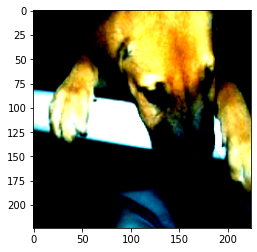

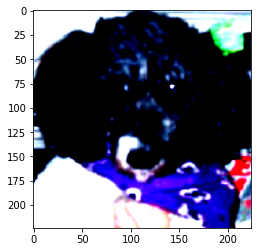

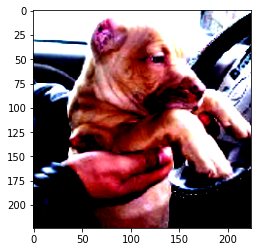

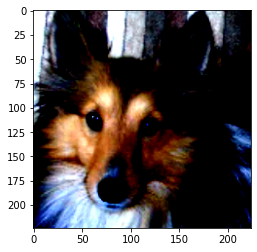

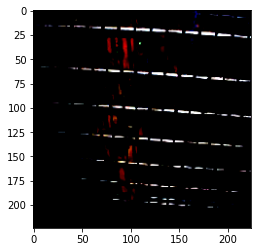

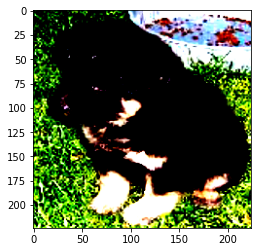

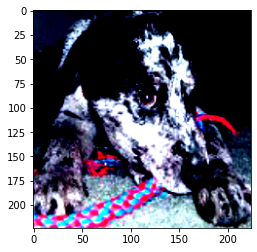

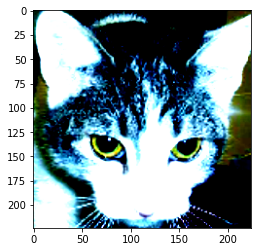

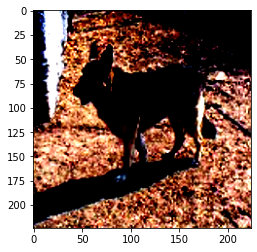

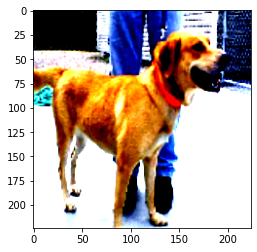

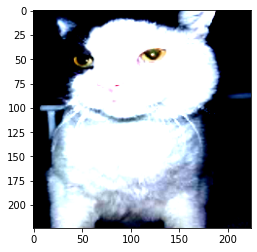

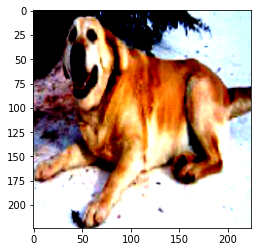

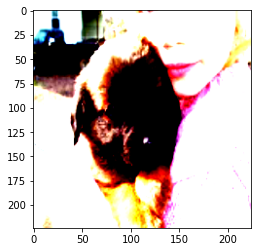

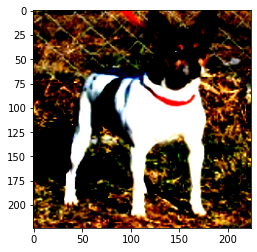

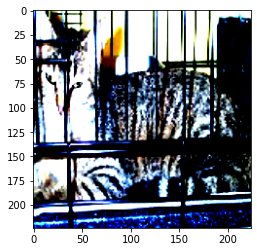

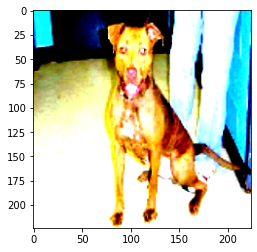

In [ ]:
correct_pred = 0
for i,data in enumerate(testloader):
    inputs,labels = data
    if i==1:
      for r in range(inputs.shape[0]):
        img = np.transpose(inputs[r], (1,2,0))
        fig,ax = plt.subplots()
        ax.imshow(img)
    
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = model(inputs)
    # Predicted class is the one with maximum probability
    preds = (output > 0.5).float()

    if i==1:
      print(preds)

    correct_pred += torch.sum(preds==labels)

test_accuracy = correct_pred.item()/300
print('Testing accuracy = ',test_accuracy*100)

In [ ]:
dataiter = iter(testloader)
data = next(dataiter)

In [ ]:
inputs,labels = data

In [ ]:
inputs = inputs.numpy()

array([[[ 0.2281874 ,  0.31381115,  0.34806067, ...,  0.15968838,
          0.21106265,  0.10831413],
        [ 0.07406463,  0.2966864 ,  0.43368444, ...,  0.1939379 ,
          0.17681314, -0.04580877],
        [-0.14855729,  0.24531215,  0.5193082 , ...,  0.21106265,
          0.15968838, -0.14855729],
        ...,
        [-0.11430778, -0.13143253, -0.14855729, ..., -1.3815396 ,
         -1.2959158 , -1.1931673 ],
        [-0.30268008, -0.2855553 , -0.25130582, ..., -1.5699118 ,
         -1.5699118 , -1.5356624 ],
        [-0.45680285, -0.42255333, -0.33692956, ..., -1.7240347 ,
         -1.7925336 , -1.843908  ]],

       [[ 0.3977592 ,  0.50280124,  0.48529422, ..., -0.35504198,
         -0.24999997, -0.28501397],
        [ 0.15266106,  0.3977592 ,  0.50280124, ..., -0.37254897,
         -0.37254897, -0.512605  ],
        [-0.19747896,  0.2226892 ,  0.5203082 , ..., -0.37254897,
         -0.42507   , -0.687675  ],
        ...,
        [-0.21498597, -0.23249297, -0.24999997, ..., -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


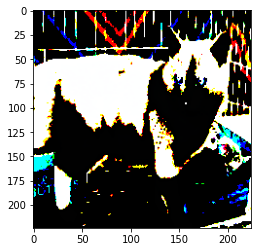

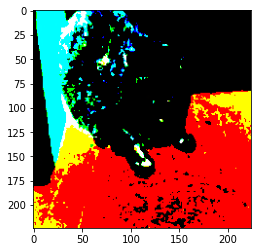

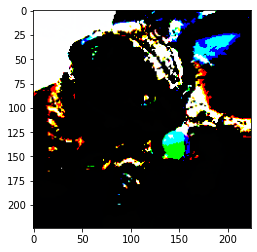

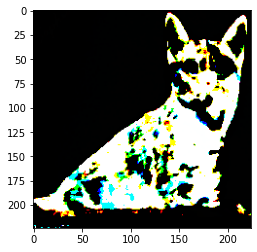

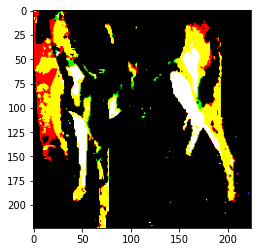

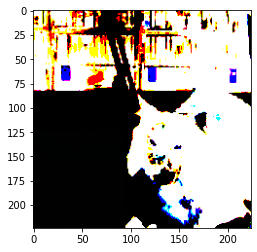

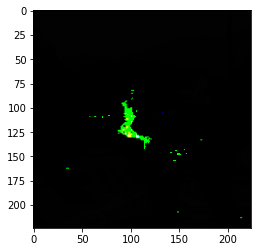

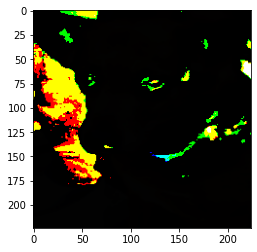

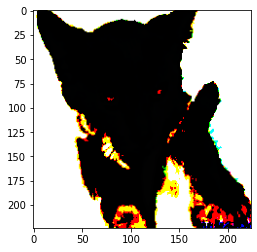

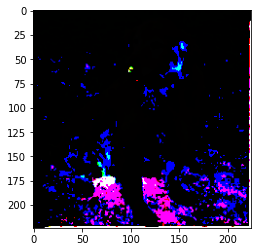

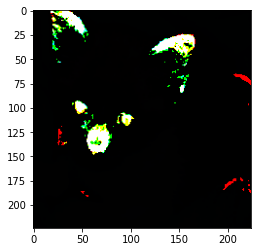

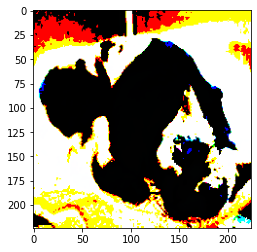

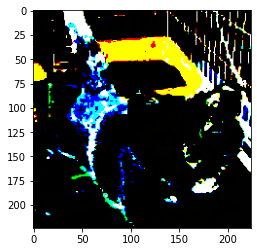

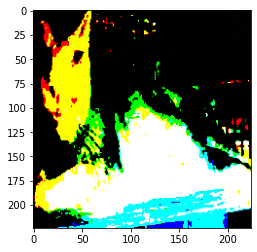

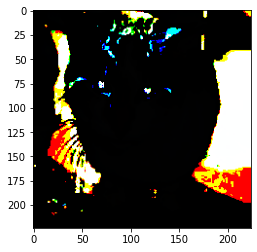

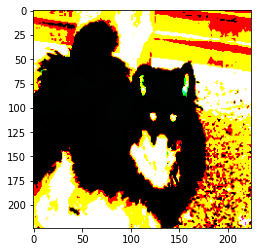

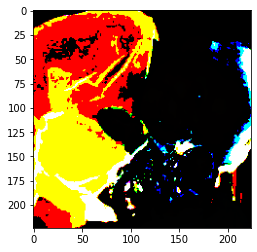

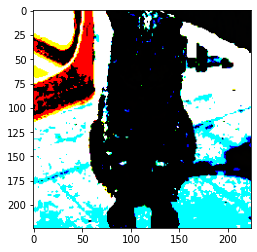

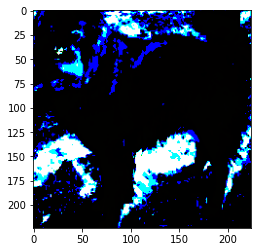

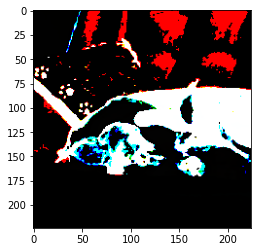

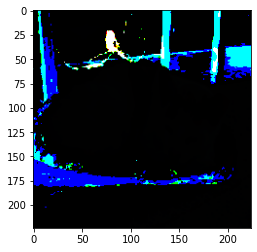

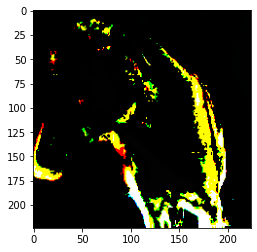

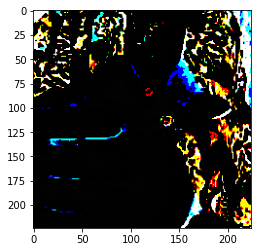

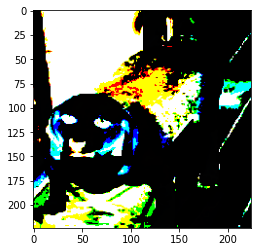

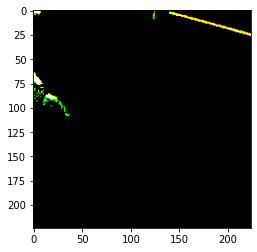

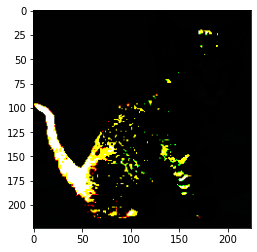

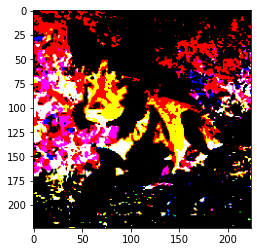

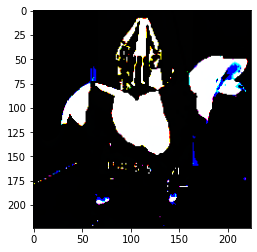

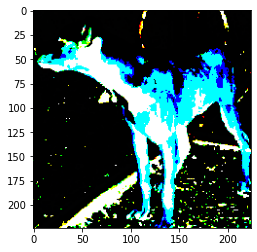

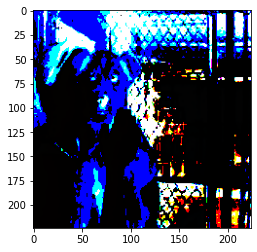

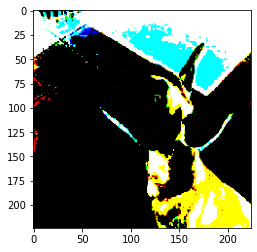

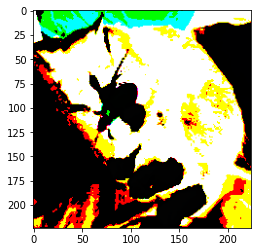

In [ ]:
for i in range(inputs.shape[0]):
  img = np.transpose(inputs[i], (1,2,0))
  fig,ax = plt.subplots()
  ax.imshow(img)

In [ ]:
img = np.transpose(inputs[0], (1,2,0))

In [ ]:
img.shape

(224, 224, 3)